<a href="https://colab.research.google.com/github/vlamen/tue-deeplearning/blob/main/assignments/assignment_1/Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Group Number:
# Student 1: Denise La Gordt Dillie
# Student 2: Andreea Maican
# Student 3: Sambhav Jain

In case you are using google colab, uncomment the following cell, and modify the ```notebook_dir``` variable to contain the directory this notebook is in. It will automatically download the .py files needed for this assignment

In [1]:
# # Change the following  line to the directory this notebook is (if using colab)
# # In case you do not know the path, open the file navigator on the left in colab
# # Find the folder containing this notebook, then press on the three dots --> copy path
# notebook_dir = "/content/drive/MyDrive/Colab Notebooks/"

In [2]:
# # UNCOMMENT IF USING COLAB
# from google.colab import drive
# import requests
# drive.mount('/content/drive')
# import sys
# import os
# sys.path.insert(0, notebook_dir) 
# os.chdir(notebook_dir)
# symco = "https://github.com/vlamen/tue-deeplearning/blob/main/assignments/assignment_1/symconv.py?raw=true"
# crpt = "https://github.com/vlamen/tue-deeplearning/blob/main/assignments/assignment_1/carpet.py?raw=true"
# r_s = requests.get(symco, allow_redirects=True)
# r_c = requests.get(crpt, allow_redirects=True)
# with open('symconv.py', 'wb') as f:
#     f.write(r_s.content)
# with open('carpet.py', 'wb') as f:
#     f.write(r_c.content)

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset

import io
import requests

import symconv as sc
from carpet import show_carpet, oh_to_label

import numpy as np
import matplotlib.pyplot as plt

from scipy.spatial.distance import cdist

from tqdm import tqdm

In [4]:
def load_numpy_arr_from_url(url):
    """
    Loads a numpy array from surfdrive. 
    
    Input:
    url: Download link of dataset 
    
    Outputs:
    dataset: numpy array with input features or labels
    """
    
    response = requests.get(url)
    response.raise_for_status()

    return np.load(io.BytesIO(response.content)) 

# Task 1: Pattern Classification

In [5]:
# loading training and testing data for task 1
# DO NOT MODIFY
task1 = load_numpy_arr_from_url("https://github.com/vlamen/tue-deeplearning/blob/main/assignments/assignment_1/task1data.npz?raw=true")
# task1 = np.load("task1data.npz")

X = torch.tensor(task1['arr_0']).float()
y = torch.tensor(task1['arr_1']).float()

X_train = X[:7500]
X_val = X[7500:9500]
X_test = X[9500:]
y_train = y[:7500]
y_val = y[7500:9500]
y_test  = y[9500:]


train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)


print(f"Carpet train shape: {X_train.shape}")
print(f"Label train shape: {y_train.shape}")
print(f"Carpet validation shape: {X_val.shape}")
print(f"Label validation shape: {y_val.shape}")
print(f"Carpet test shape: {X_test.shape}")
print(f"Label test shape: {y_test.shape}")

Carpet train shape: torch.Size([7500, 1, 96, 60])
Label train shape: torch.Size([7500, 3])
Carpet validation shape: torch.Size([2000, 1, 96, 60])
Label validation shape: torch.Size([2000, 3])
Carpet test shape: torch.Size([500, 1, 96, 60])
Label test shape: torch.Size([500, 3])


Carpet from Convolushahr


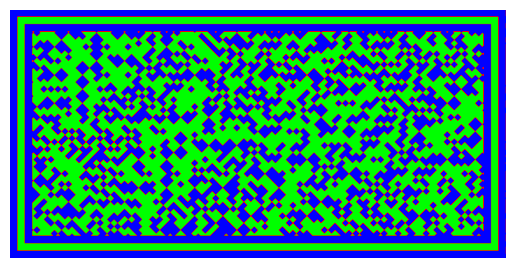

In [6]:
# random carpet
idx = np.random.randint(0,7500)
show_carpet(X_train, idx)
print('Carpet from', oh_to_label(y_train[idx,None])[0])

In [7]:
def loss_batch(model, loss_func, xb, yb, optimizer=None):
    yb = torch.argmax(yb, dim=1)

    assert yb.dim() <= 1, "Target tensor must have 0 or 1 dimensions"
    assert yb.numel() == len(xb), "Target tensor size must match input size"

    output = model(xb)
    loss = loss_func(output, yb.long())

    if optimizer is not None:
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    _, preds = torch.max(output, 1)
    corrects = torch.sum(preds == yb.long())

    return loss.item(), corrects, len(xb)

In [8]:
import matplotlib.pyplot as plt

def fit(epochs, model, loss_func, optimizer, train_dl, valid_dl, test_dl):
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    test_losses = []
    test_accs = []

    for epoch in tqdm(range(epochs)):
        # Training process
        model.train()
        running_loss = 0.0
        running_corrects = 0
        sample_num = 0

        for xb, yb in train_dl:
            losses, corrects, nums = loss_batch(model, loss_func, xb, yb, optimizer)
            running_loss += losses * xb.size(0)
            running_corrects += corrects
            sample_num += nums

        train_loss = running_loss / sample_num
        train_acc = running_corrects.double() / sample_num

        # Validation process
        model.eval()
        with torch.no_grad():
            running_loss = 0.0
            running_corrects = 0
            sample_num = 0

            for xb, yb in valid_dl:
                losses, corrects, nums = loss_batch(model, loss_func, xb, yb)
                running_loss += losses * xb.size(0)
                running_corrects += corrects
                sample_num += nums

            val_loss = running_loss / sample_num
            val_acc = running_corrects.double() / sample_num

        # Testing process
        model.eval()
        with torch.no_grad():
            running_loss = 0.0
            running_corrects = 0
            sample_num = 0

            for xb, yb in test_dl:
                losses, corrects, nums = loss_batch(model, loss_func, xb, yb)
                running_loss += losses * xb.size(0)
                running_corrects += corrects
                sample_num += nums

            test_loss = running_loss / sample_num
            test_acc = running_corrects.double() / sample_num

        # Print the results
        print(f'EPOCH: {epoch+1:0>{len(str(epochs))}}/{epochs}', end=' ')
        print(f'LOSS: {train_loss:.4f}', f'ACC: {train_acc:.4f} ', end=' ')
        print(f'VAL-LOSS: {val_loss:.4f}', f'VAL-ACC: {val_acc:.4f} ', end=' ')
        print(f'TEST-LOSS: {test_loss:.4f}', f'TEST-ACC: {test_acc:.4f} ', end='\n')

        # Save losses and accuracies
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        test_losses.append(test_loss)
        test_accs.append(test_acc)

    # Plot losses and accuracies
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, epochs+1), train_losses, 'r:', label='Train Loss')
    plt.plot(range(1, epochs+1), val_losses, 'g:', label='Validation Loss')
    plt.plot(range(1, epochs+1), test_losses, 'b:', label='Test Loss')
    plt.plot(range(1, epochs+1), train_accs, 'r', label='Train Accuracy')
    plt.plot(range(1, epochs+1), val_accs, 'g', label='Validation Accuracy')
    plt.plot(range(1, epochs+1), test_accs, 'b', label='Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Loss / Accuracy')
    plt.title('Loss and Accuracy vs. Epochs')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [9]:
def get_data(train_ds, valid_ds, batch_size):
    return (
        DataLoader(train_ds, batch_size=batch_size, shuffle=True),
        DataLoader(valid_ds, batch_size=batch_size * 2),
    )

In [10]:
batch_size = 64
train_dl, valid_dl = get_data(train_dataset, val_dataset, batch_size)
test_dl = DataLoader(test_dataset, batch_size=batch_size * 2)

In [11]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)

In [12]:
model = nn.Sequential(
    sc.Slice(rotation=4, reflection=False),
    sc.SymmetryConv2d(1, 32, kernel_size=4, stride=4, rotation=4, reflection=False),
    nn.ReLU(inplace=True),
    sc.SymmetryPool(),
    nn.BatchNorm2d(32),
    nn.Conv2d(32, 64, kernel_size=4, stride=3),
    nn.ReLU(inplace=True),
    sc.Slice(rotation=4, reflection=False),
    sc.SymmetryConv2d(64, 10, kernel_size=4, stride=1, rotation=4, reflection=False),
    nn.ReLU(inplace=True),
    sc.SymmetryPool(),
    nn.BatchNorm2d(10),
    Lambda(lambda x: x.view(x.size(0), -1)),
    nn.Linear(40, 100),
    nn.ReLU(inplace=True),
)

 10%|█         | 1/10 [00:09<01:22,  9.13s/it]

EPOCH: 01/10 LOSS: 1.5736 ACC: 0.3505  VAL-LOSS: 1.0944 VAL-ACC: 0.3835  TEST-LOSS: 1.1019 TEST-ACC: 0.3900 


 20%|██        | 2/10 [00:18<01:15,  9.44s/it]

EPOCH: 02/10 LOSS: 0.8866 ACC: 0.5684  VAL-LOSS: 0.6959 VAL-ACC: 0.6895  TEST-LOSS: 0.7344 TEST-ACC: 0.6540 


 30%|███       | 3/10 [00:28<01:07,  9.61s/it]

EPOCH: 03/10 LOSS: 0.4466 ACC: 0.8165  VAL-LOSS: 0.3629 VAL-ACC: 0.8685  TEST-LOSS: 0.3560 TEST-ACC: 0.8460 


 40%|████      | 4/10 [00:38<00:57,  9.66s/it]

EPOCH: 04/10 LOSS: 0.2153 ACC: 0.9155  VAL-LOSS: 0.2322 VAL-ACC: 0.9035  TEST-LOSS: 0.2384 TEST-ACC: 0.9160 


 50%|█████     | 5/10 [00:48<00:48,  9.69s/it]

EPOCH: 05/10 LOSS: 0.1012 ACC: 0.9645  VAL-LOSS: 0.2094 VAL-ACC: 0.9295  TEST-LOSS: 0.1825 TEST-ACC: 0.9400 


 60%|██████    | 6/10 [00:57<00:38,  9.70s/it]

EPOCH: 06/10 LOSS: 0.0703 ACC: 0.9744  VAL-LOSS: 0.2014 VAL-ACC: 0.9345  TEST-LOSS: 0.1801 TEST-ACC: 0.9420 


 70%|███████   | 7/10 [01:07<00:29,  9.71s/it]

EPOCH: 07/10 LOSS: 0.0328 ACC: 0.9876  VAL-LOSS: 0.1676 VAL-ACC: 0.9495  TEST-LOSS: 0.1909 TEST-ACC: 0.9480 


 80%|████████  | 8/10 [01:17<00:19,  9.73s/it]

EPOCH: 08/10 LOSS: 0.0257 ACC: 0.9920  VAL-LOSS: 0.1607 VAL-ACC: 0.9480  TEST-LOSS: 0.1848 TEST-ACC: 0.9460 


 90%|█████████ | 9/10 [01:27<00:09,  9.74s/it]

EPOCH: 09/10 LOSS: 0.0117 ACC: 0.9968  VAL-LOSS: 0.1630 VAL-ACC: 0.9515  TEST-LOSS: 0.1650 TEST-ACC: 0.9460 


100%|██████████| 10/10 [01:36<00:00,  9.68s/it]

EPOCH: 10/10 LOSS: 0.0063 ACC: 0.9983  VAL-LOSS: 0.1541 VAL-ACC: 0.9565  TEST-LOSS: 0.1577 TEST-ACC: 0.9520 


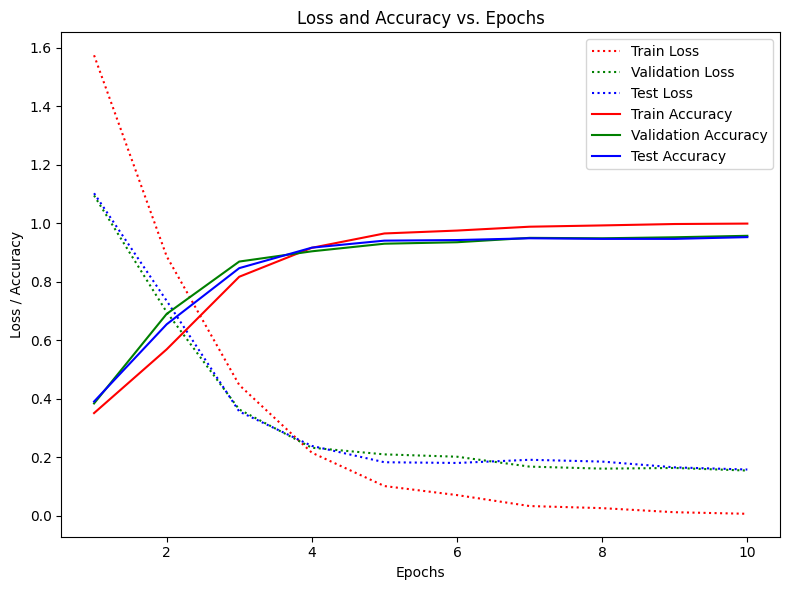

In [13]:
from torch import optim

lr = 0.1
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
epochs = 10
loss_func = F.cross_entropy

fit(epochs, model, loss_func, optimizer, train_dl, valid_dl, test_dl)

## Task 1: Question 5d

### Experiment 1
In this experiment, we change the number of convolutional filters in the model architecture. Convolutional filters are responsible for capturing different patterns and features from the input data. By altering the number of filters, we can assess the effect on the model's performance.

 10%|█         | 1/10 [00:08<01:12,  8.01s/it]

EPOCH: 01/10 LOSS: 1.4879 ACC: 0.3895  VAL-LOSS: 0.8564 VAL-ACC: 0.5970  TEST-LOSS: 0.8986 TEST-ACC: 0.5720 


 20%|██        | 2/10 [00:15<01:03,  7.97s/it]

EPOCH: 02/10 LOSS: 0.5873 ACC: 0.7392  VAL-LOSS: 0.3517 VAL-ACC: 0.8650  TEST-LOSS: 0.3442 TEST-ACC: 0.8560 


 30%|███       | 3/10 [00:23<00:55,  7.95s/it]

EPOCH: 03/10 LOSS: 0.2352 ACC: 0.9088  VAL-LOSS: 0.2288 VAL-ACC: 0.9180  TEST-LOSS: 0.1995 TEST-ACC: 0.9200 


 40%|████      | 4/10 [00:31<00:47,  7.95s/it]

EPOCH: 04/10 LOSS: 0.1390 ACC: 0.9480  VAL-LOSS: 0.3028 VAL-ACC: 0.8890  TEST-LOSS: 0.2708 TEST-ACC: 0.8880 


 50%|█████     | 5/10 [00:40<00:40,  8.07s/it]

EPOCH: 05/10 LOSS: 0.0740 ACC: 0.9732  VAL-LOSS: 0.1906 VAL-ACC: 0.9420  TEST-LOSS: 0.1708 TEST-ACC: 0.9380 


 60%|██████    | 6/10 [00:48<00:32,  8.20s/it]

EPOCH: 06/10 LOSS: 0.0728 ACC: 0.9728  VAL-LOSS: 0.1213 VAL-ACC: 0.9565  TEST-LOSS: 0.1151 TEST-ACC: 0.9540 


 70%|███████   | 7/10 [00:56<00:24,  8.28s/it]

EPOCH: 07/10 LOSS: 0.0627 ACC: 0.9775  VAL-LOSS: 0.1106 VAL-ACC: 0.9600  TEST-LOSS: 0.1046 TEST-ACC: 0.9660 


 80%|████████  | 8/10 [01:05<00:16,  8.25s/it]

EPOCH: 08/10 LOSS: 0.0460 ACC: 0.9828  VAL-LOSS: 0.0878 VAL-ACC: 0.9660  TEST-LOSS: 0.0745 TEST-ACC: 0.9720 


 90%|█████████ | 9/10 [01:13<00:08,  8.18s/it]

EPOCH: 09/10 LOSS: 0.0348 ACC: 0.9873  VAL-LOSS: 0.0869 VAL-ACC: 0.9695  TEST-LOSS: 0.0966 TEST-ACC: 0.9760 


100%|██████████| 10/10 [01:21<00:00,  8.14s/it]

EPOCH: 10/10 LOSS: 0.0302 ACC: 0.9888  VAL-LOSS: 0.1973 VAL-ACC: 0.9410  TEST-LOSS: 0.1775 TEST-ACC: 0.9540 


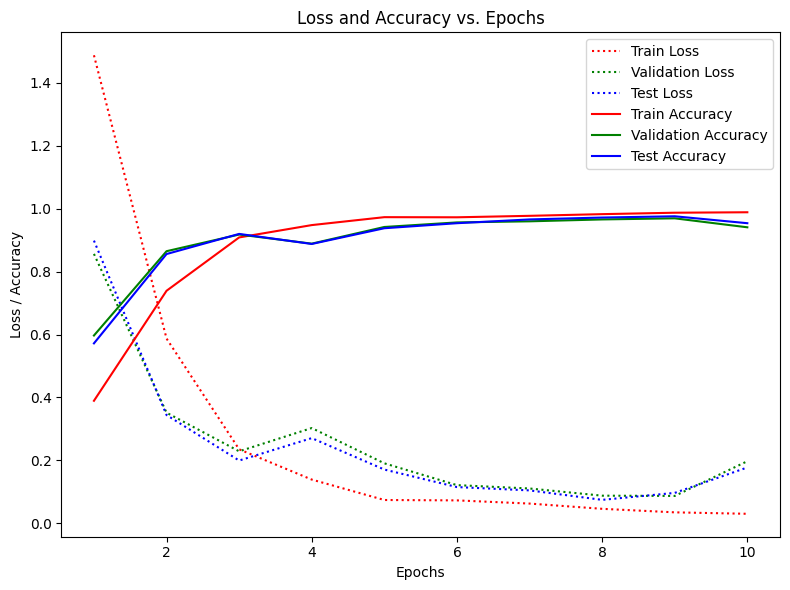

In [14]:
# Experiment 1: Change the Number of Convolutional Filters
model_exp1 = nn.Sequential(
    sc.Slice(rotation=4, reflection=False),
    sc.SymmetryConv2d(1, 16, kernel_size=4, stride=4, rotation=4, reflection=False),  # Change the number of filters to 16
    nn.ReLU(inplace=True),
    sc.SymmetryPool(),
    nn.BatchNorm2d(16),  # Adjust the batch normalization layer accordingly
    nn.Conv2d(16, 64, kernel_size=4, stride=3),
    nn.ReLU(inplace=True),
    sc.Slice(rotation=4, reflection=False),
    sc.SymmetryConv2d(64, 10, kernel_size=4, stride=1, rotation=4, reflection=False),
    nn.ReLU(inplace=True),
    sc.SymmetryPool(),
    nn.BatchNorm2d(10),
    Lambda(lambda x: x.view(x.size(0), -1)),
    nn.Linear(40, 100),
    nn.ReLU(inplace=True),
)

optimizer_exp1 = optim.SGD(model_exp1.parameters(), lr=lr, momentum=0.9)

fit(epochs, model_exp1, loss_func, optimizer_exp1, train_dl, valid_dl, test_dl)

### Experiment 2
In this experiment, we change the activation function used in the model architecture. The activation function introduces non-linearity to the model, allowing it to learn complex patterns and make non-linear predictions. By altering the activation function, we can assess its effect on the model's performance.

 10%|█         | 1/10 [00:09<01:27,  9.73s/it]

EPOCH: 01/10 LOSS: 1.5229 ACC: 0.3515  VAL-LOSS: 1.0226 VAL-ACC: 0.4815  TEST-LOSS: 1.0175 TEST-ACC: 0.4660 


 20%|██        | 2/10 [00:19<01:17,  9.66s/it]

EPOCH: 02/10 LOSS: 0.7787 ACC: 0.6333  VAL-LOSS: 0.4958 VAL-ACC: 0.8000  TEST-LOSS: 0.5050 TEST-ACC: 0.7880 


 30%|███       | 3/10 [00:29<01:07,  9.69s/it]

EPOCH: 03/10 LOSS: 0.2962 ACC: 0.8772  VAL-LOSS: 0.3776 VAL-ACC: 0.8660  TEST-LOSS: 0.3981 TEST-ACC: 0.8540 


 40%|████      | 4/10 [00:39<00:59,  9.90s/it]

EPOCH: 04/10 LOSS: 0.1308 ACC: 0.9500  VAL-LOSS: 0.2092 VAL-ACC: 0.9225  TEST-LOSS: 0.2201 TEST-ACC: 0.9140 


 50%|█████     | 5/10 [00:49<00:49,  9.99s/it]

EPOCH: 05/10 LOSS: 0.0721 ACC: 0.9728  VAL-LOSS: 0.1155 VAL-ACC: 0.9590  TEST-LOSS: 0.0878 TEST-ACC: 0.9700 


 60%|██████    | 6/10 [01:00<00:40, 10.21s/it]

EPOCH: 06/10 LOSS: 0.0461 ACC: 0.9825  VAL-LOSS: 0.1150 VAL-ACC: 0.9665  TEST-LOSS: 0.1090 TEST-ACC: 0.9600 


 70%|███████   | 7/10 [01:09<00:30, 10.06s/it]

EPOCH: 07/10 LOSS: 0.0313 ACC: 0.9891  VAL-LOSS: 0.1060 VAL-ACC: 0.9640  TEST-LOSS: 0.0671 TEST-ACC: 0.9760 


 80%|████████  | 8/10 [01:20<00:20, 10.11s/it]

EPOCH: 08/10 LOSS: 0.0165 ACC: 0.9952  VAL-LOSS: 0.0695 VAL-ACC: 0.9725  TEST-LOSS: 0.0507 TEST-ACC: 0.9760 


 90%|█████████ | 9/10 [01:30<00:10, 10.20s/it]

EPOCH: 09/10 LOSS: 0.0510 ACC: 0.9815  VAL-LOSS: 0.1357 VAL-ACC: 0.9635  TEST-LOSS: 0.0975 TEST-ACC: 0.9560 


100%|██████████| 10/10 [01:40<00:00, 10.06s/it]

EPOCH: 10/10 LOSS: 0.0221 ACC: 0.9920  VAL-LOSS: 0.0861 VAL-ACC: 0.9750  TEST-LOSS: 0.0414 TEST-ACC: 0.9760 


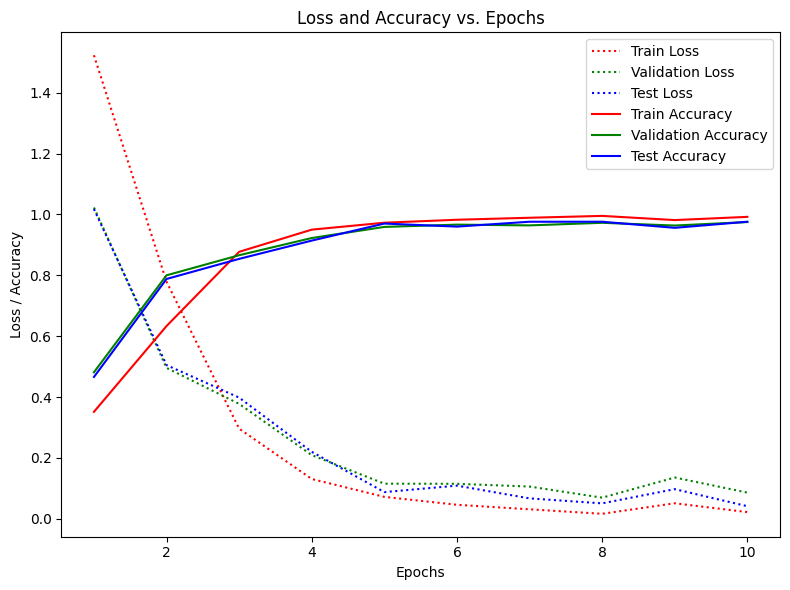

In [15]:
# Experiment 2: Change Activation Function
model_exp2 = nn.Sequential(
    sc.Slice(rotation=4, reflection=False),
    sc.SymmetryConv2d(1, 32, kernel_size=4, stride=4, rotation=4, reflection=False),
    nn.LeakyReLU(inplace=True),  # Change activation function
    sc.SymmetryPool(),
    nn.BatchNorm2d(32),
    nn.Conv2d(32, 64, kernel_size=4, stride=3),
    nn.LeakyReLU(inplace=True),  # Change activation function
    sc.Slice(rotation=4, reflection=False),
    sc.SymmetryConv2d(64, 10, kernel_size=4, stride=1, rotation=4, reflection=False),
    nn.LeakyReLU(inplace=True),  # Change activation function
    sc.SymmetryPool(),
    nn.BatchNorm2d(10),
    Lambda(lambda x: x.view(x.size(0), -1)),
    nn.Linear(40, 100),
    nn.LeakyReLU(inplace=True),  # Change activation function
)

optimizer_exp2 = optim.SGD(model_exp2.parameters(), lr=lr, momentum=0.9)

fit(epochs, model_exp2, loss_func, optimizer_exp2, train_dl, valid_dl, test_dl)

### Experiment 3
In this experiment, we change the learning rate used for training the model. The learning rate determines the step size at which the model updates its parameters during the optimization process. By adjusting the learning rate, we can explore its effect on the convergence speed and the overall performance of the model.

 10%|█         | 1/10 [00:10<01:33, 10.34s/it]

EPOCH: 01/10 LOSS: 2.9166 ACC: 0.3051  VAL-LOSS: 1.1195 VAL-ACC: 0.4110  TEST-LOSS: 1.1152 TEST-ACC: 0.4580 


 20%|██        | 2/10 [00:20<01:20, 10.04s/it]

EPOCH: 02/10 LOSS: 0.8871 ACC: 0.5827  VAL-LOSS: 0.7941 VAL-ACC: 0.6400  TEST-LOSS: 0.7794 TEST-ACC: 0.6440 


 30%|███       | 3/10 [00:29<01:08,  9.81s/it]

EPOCH: 03/10 LOSS: 0.6021 ACC: 0.7383  VAL-LOSS: 0.6766 VAL-ACC: 0.7095  TEST-LOSS: 0.6397 TEST-ACC: 0.7280 


 40%|████      | 4/10 [00:39<00:57,  9.66s/it]

EPOCH: 04/10 LOSS: 0.4168 ACC: 0.8320  VAL-LOSS: 0.6003 VAL-ACC: 0.7690  TEST-LOSS: 0.5665 TEST-ACC: 0.7760 


 50%|█████     | 5/10 [00:48<00:48,  9.72s/it]

EPOCH: 05/10 LOSS: 0.2694 ACC: 0.9021  VAL-LOSS: 0.6170 VAL-ACC: 0.7585  TEST-LOSS: 0.6097 TEST-ACC: 0.7600 


 60%|██████    | 6/10 [00:58<00:39,  9.80s/it]

EPOCH: 06/10 LOSS: 0.1871 ACC: 0.9351  VAL-LOSS: 0.5975 VAL-ACC: 0.7795  TEST-LOSS: 0.6323 TEST-ACC: 0.7600 


 70%|███████   | 7/10 [01:08<00:29,  9.83s/it]

EPOCH: 07/10 LOSS: 0.1241 ACC: 0.9601  VAL-LOSS: 0.6263 VAL-ACC: 0.7880  TEST-LOSS: 0.6423 TEST-ACC: 0.7800 


 80%|████████  | 8/10 [01:18<00:19,  9.90s/it]

EPOCH: 08/10 LOSS: 0.0864 ACC: 0.9727  VAL-LOSS: 0.6311 VAL-ACC: 0.7935  TEST-LOSS: 0.6502 TEST-ACC: 0.7960 


 90%|█████████ | 9/10 [01:28<00:09,  9.78s/it]

EPOCH: 09/10 LOSS: 0.0504 ACC: 0.9873  VAL-LOSS: 0.6836 VAL-ACC: 0.7900  TEST-LOSS: 0.7119 TEST-ACC: 0.7960 


100%|██████████| 10/10 [01:37<00:00,  9.79s/it]

EPOCH: 10/10 LOSS: 0.0331 ACC: 0.9945  VAL-LOSS: 0.7070 VAL-ACC: 0.8000  TEST-LOSS: 0.7660 TEST-ACC: 0.8080 


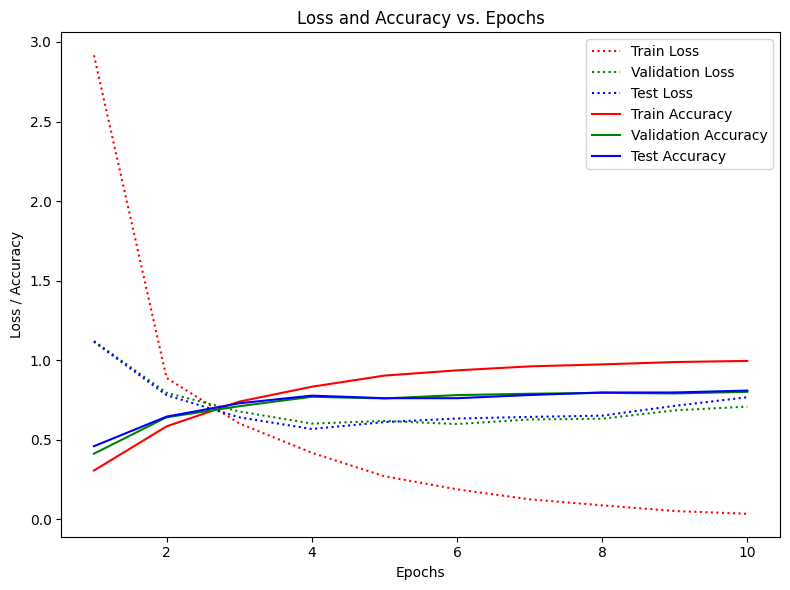

In [16]:
# Experiment 3: Adjust Learning Rate
lr_exp3 = 0.01  # Change learning rate

model_exp3 = nn.Sequential(
    sc.Slice(rotation=4, reflection=False),
    sc.SymmetryConv2d(1, 32, kernel_size=4, stride=4, rotation=4, reflection=False),
    nn.ReLU(inplace=True),
    sc.SymmetryPool(),
    nn.BatchNorm2d(32),
    nn.Conv2d(32, 64, kernel_size=4, stride=3),
    nn.ReLU(inplace=True),
    sc.Slice(rotation=4, reflection=False),
    sc.SymmetryConv2d(64, 10, kernel_size=4, stride=1, rotation=4, reflection=False),
    nn.ReLU(inplace=True),
    sc.SymmetryPool(),
    nn.BatchNorm2d(10),
    Lambda(lambda x: x.view(x.size(0), -1)),
    nn.Linear(40, 100),
    nn.ReLU(inplace=True),
)

optimizer_exp3 = optim.SGD(model_exp3.parameters(), lr=lr_exp3, momentum=0.9)

fit(epochs, model_exp3, loss_func, optimizer_exp3, train_dl, valid_dl, test_dl)

# Task 2: Carpet Matching 

In [17]:
# loading training and testing data for task 2
# DO NOT MODIFY
task2 = load_numpy_arr_from_url("https://github.com/vlamen/tue-deeplearning/blob/main/assignments/assignment_1/task2data.npz?raw=true")
# task2 = np.load('task2data.npz')

X = task2['arr_0'].astype(float)
y = task2['arr_1'].astype(float)
gt = task2['arr_2'].astype(float) # ground truth
queries = task2['arr_3'].astype(float)
targets = task2['arr_4'].astype(float)

print(f"Carpet train shape: {X.shape}")
print(f"Label train shape: {y.shape}")
print(f"Ground truth test shape: {gt.shape}")
print(f"Query carpets shape: {queries.shape}")
print(f"Candidate carpets shape: {targets.shape}")

Carpet train shape: (15000, 1, 96, 60)
Label train shape: (15000,)
Ground truth test shape: (300,)
Query carpets shape: (300, 1, 96, 60)
Candidate carpets shape: (300, 4, 1, 96, 60)


In [18]:
# # function to determine performance of model
# def query_performance(queries, targets, gt, top=1):
#     assert top >= 1
#     cnt = 0
#     for i in range(gt.shape[0]):
#
#         q = queries[i][None].float().cuda()
#         t = targets[i].float().cuda()
#
#         with torch.no_grad():
#
#
#             ### MODIFY IF NECESSARY ###
#             emb_q = net(q).cpu().numpy()
#             emb_t = net(t).cpu().numpy()
#
#             dists = cdist(emb_q, emb_t)
#
#             if top == 1:
#                 pred = np.argmin(dists)
#
#                 if pred == gt[i]:
#                     cnt += 1
#
#             else:
#                 pred = np.argsort(dists)
#                 if gt[i] in pred[0,:top].tolist():
#                     cnt+=1
#     return (100*cnt/gt.shape[0])

In [19]:
###     YOUR CODE FOR TASK 2    ###
### ADD MORE CELLS IF NECESSARY ###

In [20]:
import numpy as np
from scipy.spatial.distance import cdist
import torch
import torch.nn as nn

# Define your model for task 2
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        # Define your model architecture here
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)
        self.relu3 = nn.ReLU()
        self.avgpool = nn.AvgPool2d(4)
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(60, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.avgpool(x)
        x = self.flatten(x)
        x = self.linear(x)
        return x

# Create an instance of the model
net = Model()

# Load the pre-trained weights (if available)
# net.load_state_dict(torch.load('task2_model_weights.pth'))

# Set the device for computation
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net.to(device)

# function to determine performance of model
def query_performance(queries, targets, gt, top=1):
    assert top >= 1
    cnt = 0
    for i in range(gt.shape[0]):
        q = torch.from_numpy(queries[i][None]).float().to(device)
        t = torch.from_numpy(targets[i]).float().to(device)

        with torch.no_grad():
            emb_q = net(q).cpu().numpy()
            emb_t = net(t).cpu().numpy()

            dists = cdist(emb_q, emb_t)

            if top == 1:
                pred = np.argmin(dists)
                if pred == gt[i]:
                    cnt += 1
            else:
                pred = np.argsort(dists)
                if gt[i] in pred[0, :top].tolist():
                    cnt += 1
    return (100 * cnt / gt.shape[0])

# Test the performance of the model
top_1_accuracy = query_performance(queries, targets, gt, top=1)
top_3_accuracy = query_performance(queries, targets, gt, top=3)

In [21]:
print(top_1_accuracy)
print(top_3_accuracy)

20.0
67.33333333333333


In [22]:
import torch
import torch.nn as nn
import numpy as np
from scipy.spatial.distance import cdist

# Define the model architecture
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3)
        self.relu2 = nn.ReLU()
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(164864, num_classes)  # Adjust the input size based on your data

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.flatten(x)
        x = self.linear(x)
        return x

# Function to determine performance of the model
def query_performance(queries, targets, gt, top=1):
    assert top >= 1
    cnt = 0
    for i in range(gt.shape[0]):
        q = queries[i][None].float().to(device)
        t = targets[i].float().to(device)

        with torch.no_grad():
            emb_q = net(q)
            emb_t = net(t)

            dists = cdist(emb_q.cpu().numpy(), emb_t.cpu().numpy())

            if top == 1:
                pred = np.argmin(dists)

                if pred == gt[i]:
                    cnt += 1
            else:
                pred = np.argsort(dists)
                if gt[i] in pred[0, :top].tolist():
                    cnt += 1
    return (100 * cnt / gt.shape[0])

# Loading training and testing data for Task 2
task2 = load_numpy_arr_from_url("https://github.com/vlamen/tue-deeplearning/blob/main/assignments/assignment_1/task2data.npz?raw=true")
X = task2['arr_0'].astype(float)
y = task2['arr_1'].astype(int)
gt = task2['arr_2'].astype(int)  # Ground truth
queries = task2['arr_3'].astype(float)
targets = task2['arr_4'].astype(float)

# Determine the number of distinct classes in your dataset
num_classes = len(np.unique(y))

# Convert numpy arrays to PyTorch tensors
X = torch.from_numpy(X).float().to(device)
y = torch.from_numpy(y).long().to(device)
gt = torch.from_numpy(gt).long().to(device)
queries = torch.from_numpy(queries).float().to(device)
targets = torch.from_numpy(targets).float().to(device)

# Create an instance of the model
net = Model().to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

# Training loop
num_epochs = 1
batch_size = 32
total_samples = X.shape[0]
num_batches = total_samples // batch_size

for epoch in range(num_epochs):
    for batch_idx in range(num_batches):
        start_idx = batch_idx * batch_size
        end_idx = start_idx + batch_size

        inputs = X[start_idx:end_idx]
        labels = y[start_idx:end_idx]

        optimizer.zero_grad()

        # Forward pass
        outputs = net(inputs)

        # Compute loss
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    # Print epoch loss
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}")

# Test the performance of the model
top_1_accuracy = query_performance(queries, targets, gt, top=1)
top_3_accuracy = query_performance(queries, targets, gt, top=3)

print(f"Top-1 Accuracy: {top_1_accuracy}%")
print(f"Top-3 Accuracy: {top_3_accuracy}%")


KeyboardInterrupt: 